In [8]:
import os

assert os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] == "true"
assert os.environ["CUDA_DEVICE_ORDER"] == "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] == "0,1,2"

True

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflow_hub as tf_hub
from pathlib import Path
from sklearn.model_selection import train_test_split

In [10]:
BATCH_SIZE = 128
IMG_HEIGHT = 224
IMG_WIDTH = 224
PREPROCESS_SEED = 123

In [11]:
base_data_dir = Path(".", "input", "arch-recognizer-dataset").absolute()
train_data_dir = base_data_dir / "train"
test_data_dir = base_data_dir / "test"

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=PREPROCESS_SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=PREPROCESS_SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    label_mode="int",
    seed=PREPROCESS_SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)
class_names = train_ds.class_names
train_ds = (
    train_ds.cache()
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
val_ds = (
    val_ds.cache()
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
test_ds = (
    val_ds.cache()
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Found 9101 files belonging to 25 classes.
Using 7281 files for training.
Found 9101 files belonging to 25 classes.
Using 1820 files for validation.
Found 1012 files belonging to 25 classes.


In [13]:
augmentation_layer = tf.keras.models.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        ),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
    ]
)
model = tf.keras.models.Sequential(
    [
        augmentation_layer,
        tf.keras.layers.experimental.preprocessing.Rescaling(
            1.0 / 255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        ),
        tf_hub.KerasLayer(
            "https://tfhub.dev/sayakpaul/distill_bit_r50x1_224_feature_extraction/1",
            trainable=False,
        ),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(len(class_names)),
    ]
)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer_1 (KerasLayer)   (None, 2048)              23500352  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 25)               

In [14]:
epochs = 50
with tf.device("/device:GPU:1"):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                min_delta=0.0001, patience=10, restore_best_weights=True
            )
        ],
    )

Epoch 1/50
57/57 [==============================] - 99s 1s/step - loss: 2.2446 - accuracy: 0.3780 - val_loss: 1.4406 - val_accuracy: 0.5670
Epoch 2/50
57/57 [==============================] - 70s 1s/step - loss: 1.3944 - accuracy: 0.5800 - val_loss: 1.2127 - val_accuracy: 0.6236
Epoch 3/50
57/57 [==============================] - 70s 1s/step - loss: 1.1954 - accuracy: 0.6304 - val_loss: 1.1540 - val_accuracy: 0.6319
Epoch 4/50
57/57 [==============================] - 70s 1s/step - loss: 1.1012 - accuracy: 0.6576 - val_loss: 1.0992 - val_accuracy: 0.6407
Epoch 5/50
57/57 [==============================] - 70s 1s/step - loss: 1.0301 - accuracy: 0.6815 - val_loss: 1.0413 - val_accuracy: 0.6604
Epoch 6/50
57/57 [==============================] - 70s 1s/step - loss: 0.9626 - accuracy: 0.7017 - val_loss: 1.0266 - val_accuracy: 0.6676
Epoch 7/50
57/57 [==============================] - 70s 1s/step - loss: 0.9341 - accuracy: 0.7124 - val_loss: 1.0327 - val_accuracy: 0.6698
Epoch 8/50
57/57 [==

In [18]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 [==============================] - 14s 900ms/step - loss: 0.9535 - accuracy: 0.7071
Test Loss: 0.9535068869590759
Test Accuracy: 0.7071428298950195


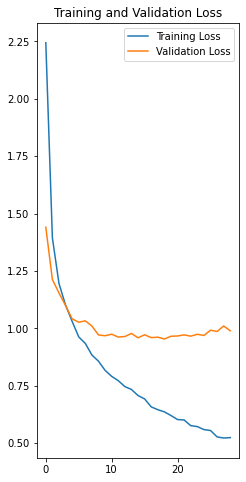

Text(0.5, 1.0, 'Training and Validation Accuracy')

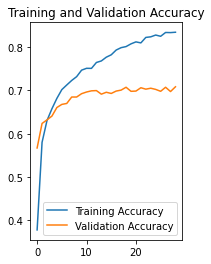

In [19]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
val_loss_range = range(len(loss))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

(-0.5, 799.5, 528.5, -0.5)

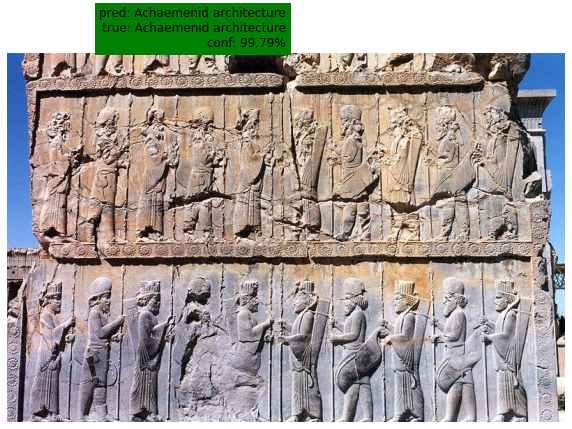

In [34]:
# sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
import random

test_dir = Path(".", "input", "g-images-dataset").absolute()
test_files = [
    os.path.join(path, filename)
    for path, dirs, files in os.walk(test_dir)
    for filename in files
    if filename.lower().endswith(".jpg")
]
img_path = Path(random.choice(test_files))

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

pred_y = class_names[np.argmax(score)]
true_y = img_path.parent.stem

plt.figure(figsize=(10, 10))
plt.title(
    f"pred: {pred_y}"
    f"\ntrue: {true_y}"
    f"\nconf: {100 * np.max(score):.2f}%",
    backgroundcolor="green" if pred_y == true_y else "red",
    horizontalalignment='right'
)
plt.imshow(tf.keras.preprocessing.image.load_img(img_path))
plt.axis("off")